IMPORTANT: This notebook is designed to be able to reproduce the O'Kane et al. (2022) results as closely as possible. This means some features of modern PyBaMM that save considerable computational resources are not used. Learning how to use these will be my next priority.

In [1]:
#import os
import matplotlib.pyplot as plt
import numpy as np
import pybamm
import pandas as pd
import timeit
start = timeit.default_timer()
#os.chdir(pybamm.__path__[0]+'/..')
# pybamm.set_logging_level("INFO")

In [2]:
model = pybamm.lithium_ion.DFN(
    options={
        "particle": "Fickian diffusion",
        "calculate discharge energy": "true",
        "SEI": "solvent-diffusion limited",
        "SEI on cracks": "true",
        "SEI film resistance": "distributed", 
        "SEI porosity change": "true",
        "particle mechanics": ("swelling and cracking", "swelling only"),
        "loss of active material": "stress-driven",
        "lithium plating": "partially reversible"
    }
)

In [3]:
chemistry = pybamm.parameter_sets.OKane2022
param = pybamm.ParameterValues(chemistry=chemistry)
param.update({"Upper voltage cut-off [V]": 4.21})
param.update({"Lower voltage cut-off [V]": 2.49})

In [4]:
total_cycles=1000
exp = pybamm.Experiment(
    [("Hold at 4.2V until C/100", "Rest for 4 hours (5 minute period)", "Discharge at C/10 until 2.5V (5 minute period)", 
    "Charge at 0.3C until 4.2V (5 minute period)", "Hold at 4.2V until C/100 (5 minute period)",)] + [(
    "Discharge at 1C until 2.5V", "Charge at 0.3C until 4.2V (5 minute period)", "Hold at 4.2V until C/100 (5 minute period)",
    ),] * total_cycles + ["Discharge at C/10 until 2.5V (5 minute period)"]
)

In [5]:
var_pts = {
    "x_n": 20,  # negative electrode
    "x_s": 20,  # separator 
    "x_p": 20,  # positive electrode
    "r_n": 30,  # negative particle
    "r_p": 30,  # positive particle
}

In [6]:
sim1 = pybamm.Simulation(
    model, 
    experiment=exp,
    parameter_values=param,
    solver=pybamm.CasadiSolver(),
    var_pts=var_pts,
)
solution1 = sim1.solve(
    save_at_cycles=[1,2,51,101,151,201,251,301,351,401,451,501,551,601,651,701,751,801,851,901,951,1001,1002]
)

stop = timeit.default_timer()
print('running time: ' + str(stop - start) +'s')

running time: 5674.176037999998s


In [7]:
path = '/mnt/c/Users/sokane/pybamm_data/OKane2022_verification/'

In [8]:
Q_throughput = solution1.summary_variables["Throughput capacity [A.h]"]
Q_sei = solution1.summary_variables["Loss of capacity to SEI [A.h]"]
Q_sei_cracks = solution1.summary_variables["Loss of capacity to SEI on cracks [A.h]"]
Q_plating = solution1.summary_variables["Loss of capacity to lithium plating [A.h]"]
Q_side = solution1.summary_variables["Total capacity lost to side reactions [A.h]"]
LAM_neg = solution1.summary_variables["Loss of active material in negative electrode [%]"]
LAM_pos = solution1.summary_variables["Loss of active material in positive electrode [%]"]

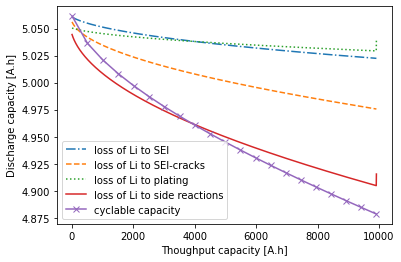

In [9]:
Q_throughput_selected = []
Q_dis_selected = []
Qdis = solution1.cycles[1].steps[0]["Discharge capacity [A.h]"].entries
Qdis_delta = Qdis[-1] - Qdis[0]
Q_dis_selected.append(Qdis_delta)
Qt = solution1.cycles[1].steps[0]["Throughput capacity [A.h]"].entries
Q_throughput_selected.append(Qt[-1])
for i in range(20):
    Qdis = solution1.cycles[50*i+50].steps[0]["Discharge capacity [A.h]"].entries
    Qdis_delta = Qdis[-1] - Qdis[0]
    Q_dis_selected.append(Qdis_delta)
    Qt = solution1.cycles[50*i+50].steps[0]["Throughput capacity [A.h]"].entries
    Q_throughput_selected.append(Qt[-1])
plt.figure()
plt.plot(Q_throughput, Q_dis_selected[0]-Q_sei, label="loss of Li to SEI", linestyle="dashdot")
plt.plot(Q_throughput, Q_dis_selected[0]-Q_sei_cracks, label="loss of Li to SEI-cracks", linestyle="dashed")
plt.plot(Q_throughput, Q_dis_selected[0]-Q_plating, label="loss of Li to plating", linestyle="dotted")
plt.plot(Q_throughput, Q_dis_selected[0]-Q_side, label="loss of Li to side reactions")
plt.plot(Q_throughput_selected, Q_dis_selected, label="cyclable capacity", marker="x")
plt.xlabel("Thoughput capacity [A.h]")
plt.ylabel("Discharge capacity [A.h]")
plt.legend()
filename = path+'FullyCoupled_reference_save_at_cycles.pdf'
plt.savefig(filename,bbox_inches='tight')
plt.show()

In [ ]:
Qdis_zero = solution1.cycles[2]["Discharge capacity [A.h]"].entries
Vdis_zero = solution1.cycles[2]["Terminal voltage [V]"].entries
eta_SEI_avg = solution1.cycles[2]["X-averaged SEI film overpotential [V]"].entries
eta_SEI_sep = solution1.cycles[2]["SEI film overpotential [V]"].entries[-1,:]
eta_SEI_CC = solution1.cycles[2]["SEI film overpotential [V]"].entries[0,:]
cs_neg_avg = solution1.cycles[2]["X-averaged negative particle surface concentration"].entries
cs_neg_sep = solution1.cycles[2]["Negative particle surface concentration"].entries[-1,:]
cs_neg_CC = solution1.cycles[2]["Negative particle surface concentration"].entries[0,:]
cs_pos_avg = solution1.cycles[2]["X-averaged positive particle surface concentration"].entries
cs_pos_sep = solution1.cycles[2]["Positive particle surface concentration"].entries[0,:]
cs_pos_CC = solution1.cycles[2]["Positive particle surface concentration"].entries[-1,:]
U_neg_avg = solution1.cycles[2]["X-averaged negative electrode open circuit potential [V]"].entries
U_neg_sep = solution1.cycles[2]["Negative electrode open circuit potential [V]"].entries[-1,:]
U_neg_CC = solution1.cycles[2]["Negative electrode open circuit potential [V]"].entries[0,:]
U_pos_avg = solution1.cycles[2]["X-averaged positive electrode open circuit potential [V]"].entries
U_pos_sep = solution1.cycles[2]["Positive electrode open circuit potential [V]"].entries[0,:]
U_pos_CC = solution1.cycles[2]["Positive electrode open circuit potential [V]"].entries[-1,:]
phis_neg_avg = solution1.cycles[2]["X-averaged negative electrode potential [V]"].entries
phis_neg_sep = solution1.cycles[2]["Negative electrode potential [V]"].entries[-1,:]
phis_neg_CC = solution1.cycles[2]["Negative electrode potential [V]"].entries[0,:]
phis_pos_avg = solution1.cycles[2]["X-averaged positive electrode potential [V]"].entries
phis_pos_sep = solution1.cycles[2]["Positive electrode potential [V]"].entries[0,:]
phis_pos_CC = solution1.cycles[2]["Positive electrode potential [V]"].entries[-1,:]
phie_neg_avg = solution1.cycles[2]["X-averaged negative electrolyte potential [V]"].entries
phie_neg_sep = solution1.cycles[2]["Negative electrolyte potential [V]"].entries[-1,:]
phie_neg_CC = solution1.cycles[2]["Negative electrolyte potential [V]"].entries[0,:]
phie_pos_avg = solution1.cycles[2]["X-averaged positive electrolyte potential [V]"].entries
phie_pos_sep = solution1.cycles[2]["Positive electrolyte potential [V]"].entries[0,:]
phie_pos_CC = solution1.cycles[2]["Positive electrolyte potential [V]"].entries[-1,:]
ce_neg_avg = solution1.cycles[2]["X-averaged negative electrolyte concentration"].entries
ce_neg_sep = solution1.cycles[2]["Negative electrolyte concentration"].entries[-1,:]
ce_neg_CC = solution1.cycles[2]["Negative electrolyte concentration"].entries[0,:]
ce_pos_avg = solution1.cycles[2]["X-averaged positive electrolyte concentration"].entries
ce_pos_sep = solution1.cycles[2]["Positive electrolyte concentration"].entries[0,:]
ce_pos_CC = solution1.cycles[2]["Positive electrolyte concentration"].entries[-1,:]
M_zero = np.array([Qdis_zero,Vdis_zero,eta_SEI_avg,eta_SEI_sep,eta_SEI_CC,
                    cs_neg_avg,cs_neg_sep,cs_neg_CC,cs_pos_avg,cs_pos_sep,cs_pos_CC,
                    U_neg_avg,U_neg_sep,U_neg_CC,U_pos_avg,U_pos_sep,U_pos_CC,
                    phis_neg_avg,phis_neg_sep,phis_neg_CC,phis_pos_avg,phis_pos_sep,phis_pos_CC,
                    phie_neg_avg,phie_neg_sep,phie_neg_CC,phie_pos_avg,phie_pos_sep,phie_pos_CC,
                    ce_neg_avg,ce_neg_sep,ce_neg_CC,ce_pos_avg,ce_pos_sep,ce_pos_CC,
])
filename_zero = path+'FullyCoupled_reference_zero.txt'
np.savetxt(filename_zero,M_zero,delimiter=",")
Qdis_first = solution1.cycles[5].steps[0]["Discharge capacity [A.h]"].entries
Vdis_first = solution1.cycles[5].steps[0]["Terminal voltage [V]"].entries
eta_SEI_avg = solution1.cycles[5].steps[0]["X-averaged SEI film overpotential [V]"].entries
eta_SEI_sep = solution1.cycles[5].steps[0]["SEI film overpotential [V]"].entries[-1,:]
eta_SEI_CC = solution1.cycles[5].steps[0]["SEI film overpotential [V]"].entries[0,:]
cs_neg_avg = solution1.cycles[5].steps[0]["X-averaged negative particle surface concentration"].entries
cs_neg_sep = solution1.cycles[5].steps[0]["Negative particle surface concentration"].entries[-1,:]
cs_neg_CC = solution1.cycles[5].steps[0]["Negative particle surface concentration"].entries[0,:]
cs_pos_avg = solution1.cycles[5].steps[0]["X-averaged positive particle surface concentration"].entries
cs_pos_sep = solution1.cycles[5].steps[0]["Positive particle surface concentration"].entries[0,:]
cs_pos_CC = solution1.cycles[5].steps[0]["Positive particle surface concentration"].entries[-1,:]
U_neg_avg = solution1.cycles[5].steps[0]["X-averaged negative electrode open circuit potential [V]"].entries
U_neg_sep = solution1.cycles[5].steps[0]["Negative electrode open circuit potential [V]"].entries[-1,:]
U_neg_CC = solution1.cycles[5].steps[0]["Negative electrode open circuit potential [V]"].entries[0,:]
U_pos_avg = solution1.cycles[5].steps[0]["X-averaged positive electrode open circuit potential [V]"].entries
U_pos_sep = solution1.cycles[5].steps[0]["Positive electrode open circuit potential [V]"].entries[0,:]
U_pos_CC = solution1.cycles[5].steps[0]["Positive electrode open circuit potential [V]"].entries[-1,:]
phis_neg_avg = solution1.cycles[5].steps[0]["X-averaged negative electrode potential [V]"].entries
phis_neg_sep = solution1.cycles[5].steps[0]["Negative electrode potential [V]"].entries[-1,:]
phis_neg_CC = solution1.cycles[5].steps[0]["Negative electrode potential [V]"].entries[0,:]
phis_pos_avg = solution1.cycles[5].steps[0]["X-averaged positive electrode potential [V]"].entries
phis_pos_sep = solution1.cycles[5].steps[0]["Positive electrode potential [V]"].entries[0,:]
phis_pos_CC = solution1.cycles[5].steps[0]["Positive electrode potential [V]"].entries[-1,:]
phie_neg_avg = solution1.cycles[5].steps[0]["X-averaged negative electrolyte potential [V]"].entries
phie_neg_sep = solution1.cycles[5].steps[0]["Negative electrolyte potential [V]"].entries[-1,:]
phie_neg_CC = solution1.cycles[5].steps[0]["Negative electrolyte potential [V]"].entries[0,:]
phie_pos_avg = solution1.cycles[5].steps[0]["X-averaged positive electrolyte potential [V]"].entries
phie_pos_sep = solution1.cycles[5].steps[0]["Positive electrolyte potential [V]"].entries[0,:]
phie_pos_CC = solution1.cycles[5].steps[0]["Positive electrolyte potential [V]"].entries[-1,:]
ce_neg_avg = solution1.cycles[5].steps[0]["X-averaged negative electrolyte concentration"].entries
ce_neg_sep = solution1.cycles[5].steps[0]["Negative electrolyte concentration"].entries[-1,:]
ce_neg_CC = solution1.cycles[5].steps[0]["Negative electrolyte concentration"].entries[0,:]
ce_pos_avg = solution1.cycles[5].steps[0]["X-averaged positive electrolyte concentration"].entries
ce_pos_sep = solution1.cycles[5].steps[0]["Positive electrolyte concentration"].entries[0,:]
ce_pos_CC = solution1.cycles[5].steps[0]["Positive electrolyte concentration"].entries[-1,:]
M_first = np.array([Qdis_first,Vdis_first,eta_SEI_avg,eta_SEI_sep,eta_SEI_CC,
                    cs_neg_avg,cs_neg_sep,cs_neg_CC,cs_pos_avg,cs_pos_sep,cs_pos_CC,
                    U_neg_avg,U_neg_sep,U_neg_CC,U_pos_avg,U_pos_sep,U_pos_CC,
                    phis_neg_avg,phis_neg_sep,phis_neg_CC,phis_pos_avg,phis_pos_sep,phis_pos_CC,
                    phie_neg_avg,phie_neg_sep,phie_neg_CC,phie_pos_avg,phie_pos_sep,phie_pos_CC,
                    ce_neg_avg,ce_neg_sep,ce_neg_CC,ce_pos_avg,ce_pos_sep,ce_pos_CC,
])
filename_first = path+'FullyCoupled_reference_first.txt'
np.savetxt(filename_first,M_first,delimiter=",")
Qdis_last = solution1.cycles[total_cycles+4].steps[0]["Discharge capacity [A.h]"].entries
Vdis_last = solution1.cycles[total_cycles+4].steps[0]["Terminal voltage [V]"].entries
eta_SEI_avg = solution1.cycles[total_cycles+4].steps[0]["X-averaged SEI film overpotential [V]"].entries
eta_SEI_sep = solution1.cycles[total_cycles+4].steps[0]["SEI film overpotential [V]"].entries[-1,:]
eta_SEI_CC = solution1.cycles[total_cycles+4].steps[0]["SEI film overpotential [V]"].entries[0,:]
cs_neg_avg = solution1.cycles[total_cycles+4].steps[0]["X-averaged negative particle surface concentration"].entries
cs_neg_sep = solution1.cycles[total_cycles+4].steps[0]["Negative particle surface concentration"].entries[-1,:]
cs_neg_CC = solution1.cycles[total_cycles+4].steps[0]["Negative particle surface concentration"].entries[0,:]
cs_pos_avg = solution1.cycles[total_cycles+4].steps[0]["X-averaged positive particle surface concentration"].entries
cs_pos_sep = solution1.cycles[total_cycles+4].steps[0]["Positive particle surface concentration"].entries[0,:]
cs_pos_CC = solution1.cycles[total_cycles+4].steps[0]["Positive particle surface concentration"].entries[-1,:]
U_neg_avg = solution1.cycles[total_cycles+4].steps[0]["X-averaged negative electrode open circuit potential [V]"].entries
U_neg_sep = solution1.cycles[total_cycles+4].steps[0]["Negative electrode open circuit potential [V]"].entries[-1,:]
U_neg_CC = solution1.cycles[total_cycles+4].steps[0]["Negative electrode open circuit potential [V]"].entries[0,:]
U_pos_avg = solution1.cycles[total_cycles+4].steps[0]["X-averaged positive electrode open circuit potential [V]"].entries
U_pos_sep = solution1.cycles[total_cycles+4].steps[0]["Positive electrode open circuit potential [V]"].entries[0,:]
U_pos_CC = solution1.cycles[total_cycles+4].steps[0]["Positive electrode open circuit potential [V]"].entries[-1,:]
phis_neg_avg = solution1.cycles[total_cycles+4].steps[0]["X-averaged negative electrode potential [V]"].entries
phis_neg_sep = solution1.cycles[total_cycles+4].steps[0]["Negative electrode potential [V]"].entries[-1,:]
phis_neg_CC = solution1.cycles[total_cycles+4].steps[0]["Negative electrode potential [V]"].entries[0,:]
phis_pos_avg = solution1.cycles[total_cycles+4].steps[0]["X-averaged positive electrode potential [V]"].entries
phis_pos_sep = solution1.cycles[total_cycles+4].steps[0]["Positive electrode potential [V]"].entries[0,:]
phis_pos_CC = solution1.cycles[total_cycles+4].steps[0]["Positive electrode potential [V]"].entries[-1,:]
phie_neg_avg = solution1.cycles[total_cycles+4].steps[0]["X-averaged negative electrolyte potential [V]"].entries
phie_neg_sep = solution1.cycles[total_cycles+4].steps[0]["Negative electrolyte potential [V]"].entries[-1,:]
phie_neg_CC = solution1.cycles[total_cycles+4].steps[0]["Negative electrolyte potential [V]"].entries[0,:]
phie_pos_avg = solution1.cycles[total_cycles+4].steps[0]["X-averaged positive electrolyte potential [V]"].entries
phie_pos_sep = solution1.cycles[total_cycles+4].steps[0]["Positive electrolyte potential [V]"].entries[0,:]
phie_pos_CC = solution1.cycles[total_cycles+4].steps[0]["Positive electrolyte potential [V]"].entries[-1,:]
ce_neg_avg = solution1.cycles[total_cycles+4].steps[0]["X-averaged negative electrolyte concentration"].entries
ce_neg_sep = solution1.cycles[total_cycles+4].steps[0]["Negative electrolyte concentration"].entries[-1,:]
ce_neg_CC = solution1.cycles[total_cycles+4].steps[0]["Negative electrolyte concentration"].entries[0,:]
ce_pos_avg = solution1.cycles[total_cycles+4].steps[0]["X-averaged positive electrolyte concentration"].entries
ce_pos_sep = solution1.cycles[total_cycles+4].steps[0]["Positive electrolyte concentration"].entries[0,:]
ce_pos_CC = solution1.cycles[total_cycles+4].steps[0]["Positive electrolyte concentration"].entries[-1,:]
M_last = np.array([Qdis_last,Vdis_last,eta_SEI_avg,eta_SEI_sep,eta_SEI_CC,
                    cs_neg_avg,cs_neg_sep,cs_neg_CC,cs_pos_avg,cs_pos_sep,cs_pos_CC,
                    U_neg_avg,U_neg_sep,U_neg_CC,U_pos_avg,U_pos_sep,U_pos_CC,
                    phis_neg_avg,phis_neg_sep,phis_neg_CC,phis_pos_avg,phis_pos_sep,phis_pos_CC,
                    phie_neg_avg,phie_neg_sep,phie_neg_CC,phie_pos_avg,phie_pos_sep,phie_pos_CC,
                    ce_neg_avg,ce_neg_sep,ce_neg_CC,ce_pos_avg,ce_pos_sep,ce_pos_CC,
])
filename_last = path+'FullyCoupled_reference_last.txt'
np.savetxt(filename_last,M_last,delimiter=",")
Qdis_eval = solution1.cycles[total_cycles+5]["Discharge capacity [A.h]"].entries
Vdis_eval = solution1.cycles[total_cycles+5]["Terminal voltage [V]"].entries
eta_SEI_avg = solution1.cycles[total_cycles+5]["X-averaged SEI film overpotential [V]"].entries
eta_SEI_sep = solution1.cycles[total_cycles+5]["SEI film overpotential [V]"].entries[-1,:]
eta_SEI_CC = solution1.cycles[total_cycles+5]["SEI film overpotential [V]"].entries[0,:]
cs_neg_avg = solution1.cycles[total_cycles+5]["X-averaged negative particle surface concentration"].entries
cs_neg_sep = solution1.cycles[total_cycles+5]["Negative particle surface concentration"].entries[-1,:]
cs_neg_CC = solution1.cycles[total_cycles+5]["Negative particle surface concentration"].entries[0,:]
cs_pos_avg = solution1.cycles[total_cycles+5]["X-averaged positive particle surface concentration"].entries
cs_pos_sep = solution1.cycles[total_cycles+5]["Positive particle surface concentration"].entries[0,:]
cs_pos_CC = solution1.cycles[total_cycles+5]["Positive particle surface concentration"].entries[-1,:]
U_neg_avg = solution1.cycles[total_cycles+5]["X-averaged negative electrode open circuit potential [V]"].entries
U_neg_sep = solution1.cycles[total_cycles+5]["Negative electrode open circuit potential [V]"].entries[-1,:]
U_neg_CC = solution1.cycles[total_cycles+5]["Negative electrode open circuit potential [V]"].entries[0,:]
U_pos_avg = solution1.cycles[total_cycles+5]["X-averaged positive electrode open circuit potential [V]"].entries
U_pos_sep = solution1.cycles[total_cycles+5]["Positive electrode open circuit potential [V]"].entries[0,:]
U_pos_CC = solution1.cycles[total_cycles+5]["Positive electrode open circuit potential [V]"].entries[-1,:]
phis_neg_avg = solution1.cycles[total_cycles+5]["X-averaged negative electrode potential [V]"].entries
phis_neg_sep = solution1.cycles[total_cycles+5]["Negative electrode potential [V]"].entries[-1,:]
phis_neg_CC = solution1.cycles[total_cycles+5]["Negative electrode potential [V]"].entries[0,:]
phis_pos_avg = solution1.cycles[total_cycles+5]["X-averaged positive electrode potential [V]"].entries
phis_pos_sep = solution1.cycles[total_cycles+5]["Positive electrode potential [V]"].entries[0,:]
phis_pos_CC = solution1.cycles[total_cycles+5]["Positive electrode potential [V]"].entries[-1,:]
phie_neg_avg = solution1.cycles[total_cycles+5]["X-averaged negative electrolyte potential [V]"].entries
phie_neg_sep = solution1.cycles[total_cycles+5]["Negative electrolyte potential [V]"].entries[-1,:]
phie_neg_CC = solution1.cycles[total_cycles+5]["Negative electrolyte potential [V]"].entries[0,:]
phie_pos_avg = solution1.cycles[total_cycles+5]["X-averaged positive electrolyte potential [V]"].entries
phie_pos_sep = solution1.cycles[total_cycles+5]["Positive electrolyte potential [V]"].entries[0,:]
phie_pos_CC = solution1.cycles[total_cycles+5]["Positive electrolyte potential [V]"].entries[-1,:]
ce_neg_avg = solution1.cycles[total_cycles+5]["X-averaged negative electrolyte concentration"].entries
ce_neg_sep = solution1.cycles[total_cycles+5]["Negative electrolyte concentration"].entries[-1,:]
ce_neg_CC = solution1.cycles[total_cycles+5]["Negative electrolyte concentration"].entries[0,:]
ce_pos_avg = solution1.cycles[total_cycles+5]["X-averaged positive electrolyte concentration"].entries
ce_pos_sep = solution1.cycles[total_cycles+5]["Positive electrolyte concentration"].entries[0,:]
ce_pos_CC = solution1.cycles[total_cycles+5]["Positive electrolyte concentration"].entries[-1,:]
M_eval = np.array([Qdis_eval,Vdis_eval,eta_SEI_avg,eta_SEI_sep,eta_SEI_CC,
                    cs_neg_avg,cs_neg_sep,cs_neg_CC,cs_pos_avg,cs_pos_sep,cs_pos_CC,
                    U_neg_avg,U_neg_sep,U_neg_CC,U_pos_avg,U_pos_sep,U_pos_CC,
                    phis_neg_avg,phis_neg_sep,phis_neg_CC,phis_pos_avg,phis_pos_sep,phis_pos_CC,
                    phie_neg_avg,phie_neg_sep,phie_neg_CC,phie_pos_avg,phie_pos_sep,phie_pos_CC,
                    ce_neg_avg,ce_neg_sep,ce_neg_CC,ce_pos_avg,ce_pos_sep,ce_pos_CC,
])
filename_eval = path+'FullyCoupled_reference_eval.txt'
np.savetxt(filename_eval,M_eval,delimiter=",")

In [ ]:
fig, ax = plt.subplots()
ax.plot(Qdis_zero,Vdis_zero,label="0.1C discharge at start")
ax.plot(Qdis_first,Vdis_first,label="First discharge",linestyle="dashed")
ax.plot(Qdis_last,Vdis_last,label="Last discharge",linestyle="dashdot")
ax.plot(Qdis_eval,Vdis_eval,label="0.1C discharge at end",linestyle="dotted")
ax.set_xlabel("Discharge capacity [A.h]")
ax.set_ylabel("Terminal voltage [V]")
ax.legend()
filename = path+"FullyCoupled_ZFLE.pdf"
plt.savefig(filename)
plt.show()